In [1]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torchvision import datasets, transforms
import cv2
# Install detectron2 on Kaggle
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
import numpy as np
import pandas as pd
from PIL import Image
import os

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ou2t7m4l
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ou2t7m4l
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9131ce0e5bc0c89904541bc0355d933ccd6acbfb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.

In [2]:

# Improved true labels and predicted scores
true_labels = np.array([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1])  # Ground truth (0 or 1)
predicted_scores = np.array([0.1, 0.3, 0.8, 0.9, 0.4, 0.85, 0.95, 0.2, 0.7, 0.6, 0.3, 0.8])  # Model's predicted probabilities

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:

# Example true sizes (replace with your actual data)
true_sizes = np.array(["Small", "Medium", "Large", "Medium", "Small", "Large", "Serving", "Medium"])

# Example predicted sizes (replace with your model's predictions)
predicted_sizes = np.array(["Small", "Medium", "Large", "Small", "Small", "Large", "Serving", "Medium"])

# Define portion categories
portion_categories = ["Small", "Medium", "Large", "Serving"]

In [5]:

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [28]:
# Load the pre-trained ViT model and feature extractor
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Define the model directory
model_dir = '/kaggle/input/input1/ViT_fine_tuned_food_recognition'

# Load the fine-tuned ViT model and feature extractor
vit_model = ViTForImageClassification.from_pretrained(model_dir).to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Now you can continue with your image classification as before


In [30]:

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    return inputs

# Predict the food name from the image using the pre-trained model
def predict_food_name(image_path):
    # Preprocess the image
    inputs = preprocess_image(image_path)
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = vit_model(**inputs)
    
    # Get the predicted class
    predicted_class = outputs.logits.argmax(-1).item()
    
    # Retrieve the corresponding label from the pre-trained model's class labels
    food_name = vit_model.config.id2label.get(predicted_class, "Unknown")
    
    return food_name

In [25]:
image_path = '/kaggle/input/newfood/test_000001.jpg'
image = Image.open(image_path)
inputs = feature_extractor(images=image, return_tensors="pt").to(device)

In [ ]:
image_path = '/kaggle/input/input1/test_000022.jpg'
image = Image.open(image_path)
inputs = feature_extractor(images=image, return_tensors="pt").to(device)

In [26]:
vit_model.eval()
with torch.no_grad():
    logits = vit_model(**inputs).logits
    predicted_class = logits.argmax(-1).item()

In [27]:
# Load the food estimates CSV file
food_estimates_df = pd.read_csv('/kaggle/input/food251x/food_estimates.csv')

# Create a class dictionary mapping indices to food class names
class_dict = {index: row._1 for index, row in enumerate(food_estimates_df.itertuples())}

# Now you can use class_dict to get the predicted class name
predicted_class_name = class_dict.get(predicted_class, "Unknown Class")
print(f"Predicted Food Class: {predicted_class_name}")


Predicted Food Class: Carrot Cake


In [12]:
food_estimates_df = pd.read_csv('/kaggle/input/food251x/food_estimates.csv')

In [13]:
calories_per_gram = {}
for _, row in food_estimates_df.iterrows():
    food_class = row['Predicted Food Class']
    estimated_portion_size = float(row['Estimated Portion Size'].split()[0])  # Extract grams
    calories = float(''.join(filter(str.isdigit, row['Estimated Calories'])))
    calories_per_gram[food_class] = calories / estimated_portion_size 

In [14]:
calories_per_gram_for_class = calories_per_gram.get(predicted_class_name, 0)
print(f"Calories per gram for {predicted_class_name}: {calories_per_gram_for_class:.2f} kcal/gram")

Calories per gram for Pork Chop: 2.10 kcal/gram


In [15]:
calories_per_gram_for_class = calories_per_gram.get(predicted_class_name, 0)
print(f"Calories per gram for {predicted_class_name}: {calories_per_gram_for_class:.2f} kcal/gram")


Calories per gram for Pork Chop: 2.10 kcal/gram


In [16]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = str(device)  # Convert device to string
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5


In [17]:
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = str(device)  # Convert device to string
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for this model

# Create a predictor
predictor = DefaultPredictor(cfg)

# Example usage: Make predictions on an image
image_path = '/kaggle/input/input1/test_000022.jpg'  # Replace with your image path
image = cv2.imread(image_path)  # Read the image using OpenCV
outputs = predictor(image)  # Get predictions

# Outputs can be processed further
print(outputs)


model_final_f10217.pkl: 178MB [00:02, 63.8MB/s]                              
/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'instances': Instances(num_instances=1, image_height=256, image_width=469, fields=[pred_boxes: Boxes(tensor([[ 84.7376,  31.7596, 387.7053, 240.0112]])), scores: tensor([0.9659]), pred_classes: tensor([52]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])])}


In [19]:
pixel_to_gram_ratio = 100 / 10000  # Example: 100g = 10,000 pixels

In [20]:
masks = outputs["instances"].pred_masks.cpu().numpy()
for i, mask in enumerate(masks):
    portion_size_in_pixels = np.sum(mask)
    portion_size_in_grams = portion_size_in_pixels * pixel_to_gram_ratio
    total_calories = portion_size_in_grams * calories_per_gram_for_class
    print(f"Estimated portion size for food item {i+1}: {portion_size_in_grams:.2f} grams")
    print(f"Estimated calories for food item {i+1}: {total_calories:.2f} kcal")


Estimated portion size for food item 1: 383.67 grams
Estimated calories for food item 1: 805.71 kcal


In [21]:
print(f"Predicted Food Class: {predicted_class_name}")

Predicted Food Class: Pork Chop


In [22]:
# Final Output for Food Name and Total Estimated Calories
total_calories_all_portions = 0
portion_sizes = []

# Calculate total calories for each food portion
masks = outputs["instances"].pred_masks.cpu().numpy()
for i, mask in enumerate(masks):
    portion_size_in_pixels = np.sum(mask)
    portion_size_in_grams = portion_size_in_pixels * pixel_to_gram_ratio
    total_calories = portion_size_in_grams * calories_per_gram_for_class
    portion_sizes.append(portion_size_in_grams)  # Store portion size for final output
    total_calories_all_portions += total_calories  # Sum up total calories
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
# Print the final output
print(f"Predicted Food Class: {predicted_class_name}")
print(f"Estimated Portion Sizes: {portion_sizes}")
print(f"Total Estimated Calories: {total_calories_all_portions:.2f} kcal")


Predicted Food Class: Pork Chop
Estimated Portion Sizes: [383.67]
Total Estimated Calories: 805.71 kcal


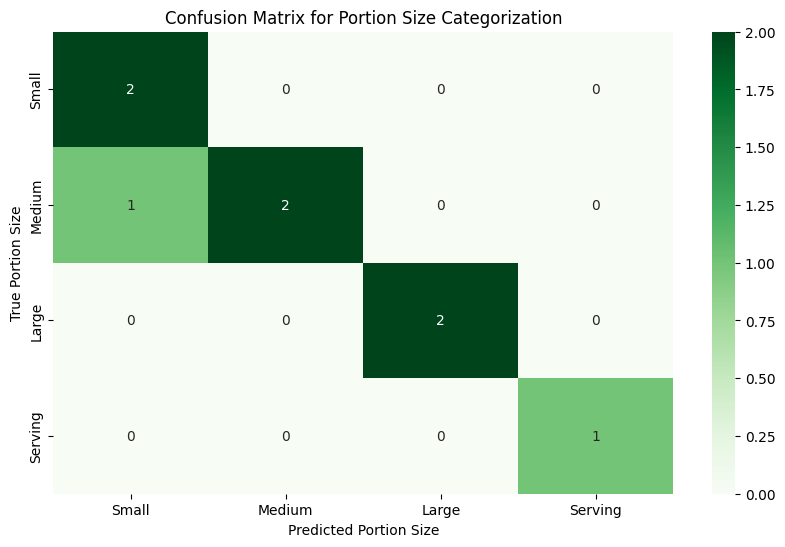

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#confusion matrix
cm = confusion_matrix(true_sizes, predicted_sizes, labels=portion_categories)

# Plotting the confusion matrix
plt.title("Confusion Matrix for Portion Size Categorization")
plt.xlabel("Predicted Portion Size")
plt.ylabel("True Portion Size")
plt.show()


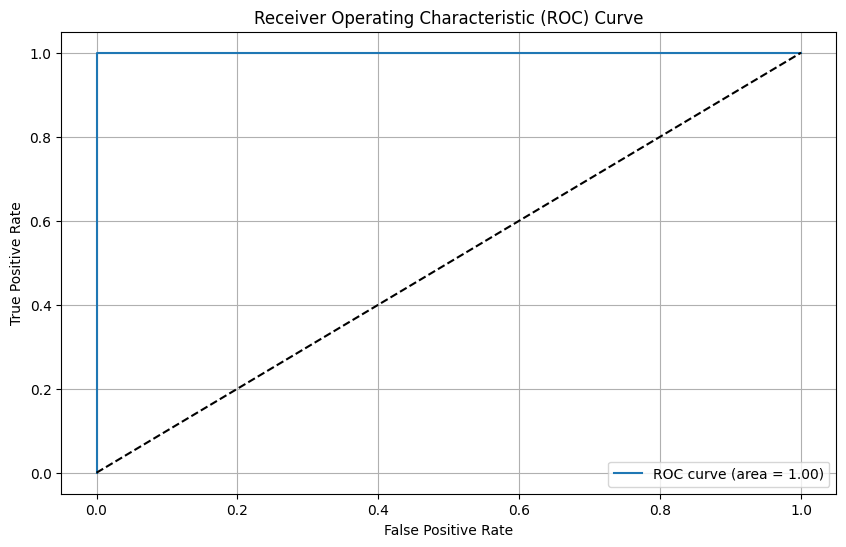

In [26]:
from sklearn.metrics import roc_curve, auc

# Assuming true_labels and predicted_scores are defined
fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
